## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [95]:
%matplotlib inline

In [114]:
import matplotlib.pyplot as plt

import pandas
import root_pandas
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import cross_val_score

### Download data

In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

### Read the smallest part of training file and test file

In [97]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))
small_data = data#[0:500]

### Define training features

Exclude `event_id`, `target` from the features set

In [98]:
features = list(set(data.columns) - {'event_id', 'target'})
#target = data["target"]
#features

### Prepare high-level features for training

In [99]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv', 'lepton_pt', 'mem_pt', 'mem_phi']
#high_level_features = ['m_bb', 'm_wwbb']

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [100]:
training_data, validation_data = train_test_split(small_data, random_state=11, train_size=0.66)

### Try a decision tree

max score:  0.706248718103
best n depths:  6


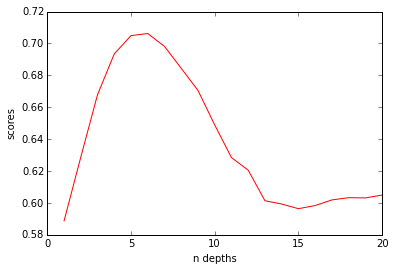

In [101]:
#tree = DecisionTreeClassifier(max_depth=3).fit(data[high_level_features], data.target)
depths = [a for a in range(1,21)]
scores = []
massimo_x = 0
massimo_y = 0
for i in depths:
    cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=i).fit(training_data[high_level_features], training_data.target), training_data[high_level_features], training_data.target, scoring='roc_auc', n_jobs=4, cv=10)
    scores.append(np.mean(cv_scores))
    if scores[i-1] > massimo_y:
#        print "aljdf"
        massimo_x = i
        massimo_y = scores[i-1]
print "max score: ", np.max(scores)
print "best n depths: ", massimo_x
#print scores
import matplotlib.pyplot as plt2
%matplotlib inline
plt2.plot(depths, scores, '-r')#in red
plt2.xlabel("n depths")
plt2.ylabel("scores")

### Tree without cv

In [102]:
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=100, metric='manhattan')
#knn.fit(training_data[high_level_features], training_data.target)
tree = DecisionTreeClassifier(max_depth=massimo_x).fit(data[high_level_features], data.target)

In [103]:
# predict validation sample (probability for each event)
#proba = knn.predict_proba(validation_data[high_level_features])
proba = tree.predict_proba(validation_data[high_level_features])

In [104]:
proba

array([[ 0.66563945,  0.33436055],
       [ 0.23577236,  0.76422764],
       [ 0.44285714,  0.55714286],
       ..., 
       [ 0.52      ,  0.48      ],
       [ 0.44285714,  0.55714286],
       [ 0.50909091,  0.49090909]])

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

In [105]:
# take probability to be 1 class to compute ROC AUC
roc_auc_score(validation_data.target, proba[:, 1])

0.75929351674405776

### Tree with cv

In [108]:
cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=massimo_x).fit(training_data[high_level_features], training_data.target), training_data[high_level_features], training_data.target, scoring='roc_auc', n_jobs=4, cv=100)
print cv_scores.mean()

0.707316385049


## Prepare submission to kaggle

In [ ]:
# predict test sample
#kaggle_proba = knn.predict_proba(test[high_level_features])[:, 1]
print tree
kaggle_proba = tree.predict_proba(test[high_level_features])[:, 1]
print kaggle_proba[:, 1]
kaggle_ids = test.event_id

In [64]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='silly_DecisionTree.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/notebooks/higgs_kaggle/datasets/silly_DecisionTree.csv